In [1]:
import re
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
#!pip install seaborn
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
from sklearn import metrics
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
df_train = pd.read_csv(r'train.tsv', sep='\t')
df_test = pd.read_csv(r'test.tsv', sep='\t')

In [4]:
df_test.head(20)

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


In [5]:
stop_word = set(stopwords.words('english')) 
word_vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word', min_df=0.01)
sparse_matrix = word_vectorizer.fit_transform(df_test['Phrase'])
frequencies = sum(sparse_matrix).toarray()[0]
freq = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
freq.sort_values('frequency', ascending=False)

,frequency
the,20181
and,12594
of,12508
to,9142
in,5658
...,...
little,709
can,704
if,698
make,696


<AxesSubplot:xlabel='Rating', ylabel='Sentiment'>

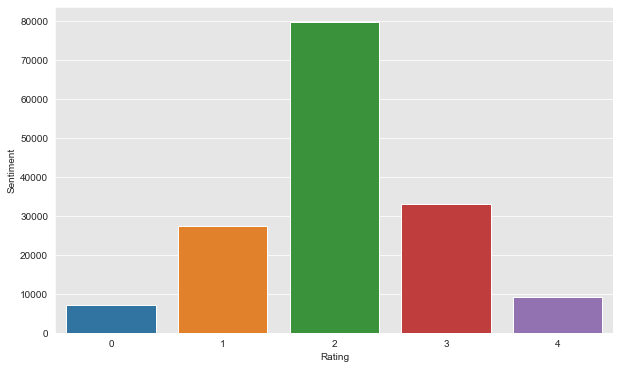

In [6]:
a = df_train.Sentiment.value_counts()
a = pd.DataFrame(a)
a['Rating'] = a.index
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(y='Sentiment', x='Rating', data=a)

In [7]:
df_train['Phrase'] = df_train['Phrase'].str.lower()
df_train['Phrase'] = df_train['Phrase'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
df_test['Phrase'] = df_test['Phrase'].str.lower()
df_test['Phrase'] = df_test['Phrase'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [8]:
X_train = df_train.Phrase
y_train = df_train.Sentiment
tokenize = Tokenizer()
tokenize.fit_on_texts(X_train.values)

In [9]:
X_test = df_test.Phrase
X_train = tokenize.texts_to_sequences(X_train)
X_test = tokenize.texts_to_sequences(X_test)

In [10]:
max_lenght = max([len(s.split()) for s in df_train['Phrase']])
X_train = pad_sequences(X_train, max_lenght)
X_test = pad_sequences(X_test, max_lenght)

In [11]:
print(X_train.shape)
print(X_test.shape)

(156060, 48)
(66292, 48)


In [12]:
#Model Building with 3 layers
EMBEDDING_DIM = 100
unknown = len(tokenize.word_index)+1
model = Sequential()
model.add(Embedding(unknown, EMBEDDING_DIM, input_length=max_lenght))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2 ))
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48, 100)           1637800   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 1,755,693
Trainable params: 1,755,693
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
print(y_train.shape)
print(X_train.shape)

(156060,)
(156060, 48)


In [15]:
history = model.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, callbacks = [
                                        tensorflow.keras.callbacks.EarlyStopping(monitor='loss',patience = 3)])

Epoch 1/15
1220/1220 [==============================] - 264s 216ms/step - loss: 0.9568 - accuracy: 0.6136
Epoch 2/15
1220/1220 [==============================] - 264s 216ms/step - loss: 0.7624 - accuracy: 0.6845
Epoch 3/15
1220/1220 [==============================] - 263s 216ms/step - loss: 0.6966 - accuracy: 0.7096
Epoch 4/15
1220/1220 [==============================] - 264s 216ms/step - loss: 0.6477 - accuracy: 0.7271
Epoch 5/15
1220/1220 [==============================] - 278s 228ms/step - loss: 0.6087 - accuracy: 0.7415
Epoch 6/15
1220/1220 [==============================] - 293s 240ms/step - loss: 0.5773 - accuracy: 0.7521
Epoch 7/15
1220/1220 [==============================] - 307s 252ms/step - loss: 0.5499 - accuracy: 0.7620
Epoch 8/15
1220/1220 [==============================] - 285s 233ms/step - loss: 0.5269 - accuracy: 0.7703
Epoch 9/15
1220/1220 [==============================] - 283s 232ms/step - loss: 0.5049 - accuracy: 0.7791
Epoch 10/15
1220/1220 [=======================

In [16]:
final_pred = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


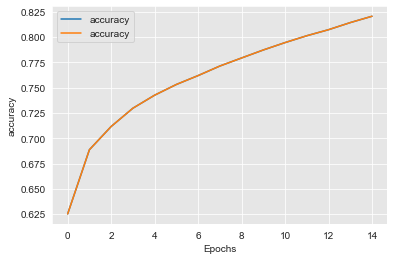

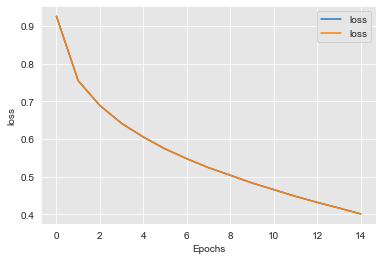

In [23]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, string])
    plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [18]:
# history = model.fit(np.array(X_train), np.array(y_train), batch_size=128, epochs=7, verbose=1, callbacks = [
#                                        tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 5)
#                                    ])
model.save('sentimentmodel.h5', history)

In [16]:
final_pred = model.predict_classes(X_test)
print(final_pred)


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[2 2 2 ... 1 1 1]


In [ ]:
final_pred = model.predict_classes(X_test)

# Naive Bayes

In [17]:
from sklearn.metrics import classification_report,confusion_matrix

In [13]:
df_train = pd.read_csv(r'train.tsv', sep='\t')
df_train['Phrase'] = df_train['Phrase'].str.lower()
stop_word = set(stopwords.words('english')) 
df_train['tokezines_sents'] = df_train.apply(lambda x: nltk.word_tokenize(x['Phrase']),axis=1)





In [14]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
df_train['tokezines_sents'] = df_train['tokezines_sents'].apply(lambda x: [stemmer.stem(y) for y in x])
df_train['tokezines_sents'] = df_train['tokezines_sents'].apply(lambda x: ' '.join(x))

In [15]:
from sklearn.model_selection import train_test_split
x=df_train.tokezines_sents
y=df_train.Sentiment
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,  random_state=1)
x_train_df = vect.fit_transform(X_train)
x_test_df = vect.transform(X_test)
print('Number of features:', len(vect.get_feature_names()))

Number of features: 10730


In [19]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train_df, y_train)
y_pred_class = nb.predict(x_test_df)
print('NB:', metrics.accuracy_score(y_test, y_pred_class))

NB: 0.612392669486095


In [18]:
print(classification_report( y_test,y_pred_class))

              precision    recall  f1-score   support

           0       0.45      0.28      0.35      1419
           1       0.50      0.42      0.46      5512
           2       0.69      0.79      0.74     15964
           3       0.53      0.48      0.50      6554
           4       0.47      0.31      0.37      1763

    accuracy                           0.61     31212
   macro avg       0.53      0.46      0.48     31212
weighted avg       0.60      0.61      0.60     31212



# SVM

In [16]:
from sklearn.linear_model import SGDClassifier
SVM = SGDClassifier()
SVM.fit(x_train_df, y_train)
y_pred_class = SVM.predict(x_test_df)
print('SVM:', metrics.accuracy_score(y_test, y_pred_class))

SVM: 0.6082916826861463


In [20]:
print(classification_report( y_test,y_pred_class))

              precision    recall  f1-score   support

           0       0.46      0.27      0.34      1419
           1       0.53      0.24      0.33      5512
           2       0.63      0.91      0.75     15964
           3       0.57      0.34      0.43      6554
           4       0.52      0.29      0.37      1763

    accuracy                           0.61     31212
   macro avg       0.54      0.41      0.44     31212
weighted avg       0.59      0.61      0.57     31212



# Random Forest Classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train_df, y_train)
y_pred_class = rfc.predict(x_test_df)
print('RF:',metrics.accuracy_score(y_test, y_pred_class))

RF: 0.6336985774702037


In [25]:
print(classification_report( y_test,y_pred_class))

              precision    recall  f1-score   support

           0       0.47      0.38      0.42      1419
           1       0.54      0.46      0.50      5512
           2       0.71      0.80      0.75     15964
           3       0.55      0.50      0.53      6554
           4       0.47      0.38      0.42      1763

    accuracy                           0.63     31212
   macro avg       0.55      0.50      0.52     31212
weighted avg       0.62      0.63      0.63     31212



AxesSubplot(0.125,0.125;0.62x0.755)


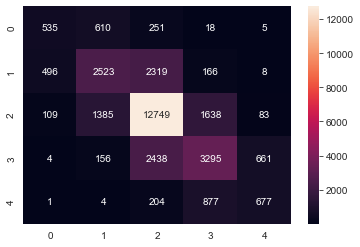

In [26]:
print(sns.heatmap(confusion_matrix(y_test,y_pred_class),annot=True,fmt=''))

In [26]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()


In [27]:
def get_scores(Phrase):
    sia_scores = sia.polarity_scores(Phrase)
    
    return pd.Series({
        'Phrase': Phrase,
        'nltk': sia_scores,
    })

scores = df_test.Phrase.apply(get_scores)

In [28]:
scores.head(5)

,Phrase,nltk
0,An intermittently pleasing but mostly routine ...,"{'neg': 0.0, 'neu': 0.732, 'pos': 0.268, 'comp..."
1,An intermittently pleasing but mostly routine ...,"{'neg': 0.0, 'neu': 0.732, 'pos': 0.268, 'comp..."
2,An,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,intermittently pleasing but mostly routine effort,"{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'comp..."
4,intermittently pleasing but mostly routine,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp..."


In [29]:
df_test['scores'] = df_test['Phrase'].apply(lambda Phrase: sia.polarity_scores(Phrase))

df_test.head()

,PhraseId,SentenceId,Phrase,scores
0,156061,8545,An intermittently pleasing but mostly routine ...,"{'neg': 0.0, 'neu': 0.732, 'pos': 0.268, 'comp..."
1,156062,8545,An intermittently pleasing but mostly routine ...,"{'neg': 0.0, 'neu': 0.732, 'pos': 0.268, 'comp..."
2,156063,8545,An,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,156064,8545,intermittently pleasing but mostly routine effort,"{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'comp..."
4,156065,8545,intermittently pleasing but mostly routine,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp..."


In [30]:
df_test['compound']  = df_test['scores'].apply(lambda score_dict: score_dict['compound'])

df_test.head()

,PhraseId,SentenceId,Phrase,scores,compound
0,156061,8545,An intermittently pleasing but mostly routine ...,"{'neg': 0.0, 'neu': 0.732, 'pos': 0.268, 'comp...",0.296
1,156062,8545,An intermittently pleasing but mostly routine ...,"{'neg': 0.0, 'neu': 0.732, 'pos': 0.268, 'comp...",0.296
2,156063,8545,An,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000
3,156064,8545,intermittently pleasing but mostly routine effort,"{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'comp...",0.296
4,156065,8545,intermittently pleasing but mostly routine,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.296


In [39]:
df_test['comp_score'] = df_test['compound'].apply(lambda c: 'pos' if c >=0.05 else ('neg' if c <=-0.05 else 'neu'))

df_test.head()

,PhraseId,SentenceId,Phrase,scores,compound,comp_score
0,156061,8545,An intermittently pleasing but mostly routine ...,"{'neg': 0.0, 'neu': 0.732, 'pos': 0.268, 'comp...",0.296,pos
1,156062,8545,An intermittently pleasing but mostly routine ...,"{'neg': 0.0, 'neu': 0.732, 'pos': 0.268, 'comp...",0.296,pos
2,156063,8545,An,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,neu
3,156064,8545,intermittently pleasing but mostly routine effort,"{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'comp...",0.296,pos
4,156065,8545,intermittently pleasing but mostly routine,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.296,pos


In [40]:
df_test['comp_score'] = df_test['compound'].apply(lambda c: 'positive' if c >=0.65 else ('somewhat positive' if c>=0.25 and c<0.65 else('neutral' if c>-0.25 and c<=0.25 else('somewhat negative' if c<-0.25 and c>=-0.65 else 'negative'))))

df_test.head()

,PhraseId,SentenceId,Phrase,scores,compound,comp_score
0,156061,8545,An intermittently pleasing but mostly routine ...,"{'neg': 0.0, 'neu': 0.732, 'pos': 0.268, 'comp...",0.296,somewhat positive
1,156062,8545,An intermittently pleasing but mostly routine ...,"{'neg': 0.0, 'neu': 0.732, 'pos': 0.268, 'comp...",0.296,somewhat positive
2,156063,8545,An,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,neutral
3,156064,8545,intermittently pleasing but mostly routine effort,"{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'comp...",0.296,somewhat positive
4,156065,8545,intermittently pleasing but mostly routine,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.296,somewhat positive


In [41]:
df_test.iloc[[546]]

,PhraseId,SentenceId,Phrase,scores,compound,comp_score
546,156607,8560,Chilling but uncommercial look into the mind o...,"{'neg': 0.412, 'neu': 0.588, 'pos': 0.0, 'comp...",-0.7906,negative


In [30]:
import pickle

In [1]:
import anvil.server

In [2]:
anvil.server.connect("PUGTXVK52ZGAB2VCGNJY2BFH-XRCGMEW32EOHZ5F5")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment (dev)" as SERVER


In [5]:
# 
# @anvil.server.callable
#def predict_text(sentiment_text):
#    sentiment_text = [sentiment_text]
#    sentiment_text = vect.transform(sentiment_text)
#    final_pred = nb.predict(sentiment_text)
#    return final_pred

In [189]:
#@anvil.server.callable
#def predict_text(sentiment_text):
#    sentiment_text = [sentiment_text]
#    sentiment_text = vect.transform(sentiment_text)
#    dtrfc = rfc.predict(sentiment_text)
#    return dtrfc

In [19]:
#@anvil.server.callable
#def predict_text(sentiment_text):
#    sentiment_text = [sentiment_text]
#    sentiment_text = vect.transform(sentiment_text)
#    SVM_PRED = SVM.predict(sentiment_text)
#    return SVM_PRED

In [3]:
from nltk.sentiment import SentimentIntensityAnalyzer

@anvil.server.callable
def predict_text(sentiment_text):
    sia = SentimentIntensityAnalyzer()
    sia_scores = sia.polarity_scores(sentiment_text)
    pos = sia_scores["pos"]
    neu = sia_scores["neu"]
    neg = sia_scores["neg"]
    compound = sia_scores["compound"]
    positive = (f'The percentage of positive sentiment is : {round(pos*100,2)} %')
    neutral = (f'The percentage of neutral sentiment is : {round(neu*100,2)} %')
    negative = (f'The percentage of negative sentiment is : {round(neg*100,2)} %')
    if compound <= -0.65:
        compound = (f'The sentence is collectively: Negative')
    elif compound <-0.25:
        if compound > -0.65:
            compound = ('The sentence is collectively: Somewhat negative')
    elif compound <= 0.25:
        if compound > -0.25:
            compound = ('The sentence is collectively: Neutral')
    elif compound < 0.65:
        if compound > 0.25:
            compound = ('The sentence is collectively: Somewhat Positive')
    else:
        compound = ('The sentence is collectively: Positive')
    
    sentiment_text = [sentiment_text]

    return ({

        'nltk': sia_scores,
        'positive': positive,
        'neutral': neutral,
        'negative': negative,
        'compound': compound,
        
    })


In [1]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.field_names=["Model Name","Test Accuracy"]
ptable.add_row(["SVM","61%"])
ptable.add_row(["Naive Bayes","61%"])
ptable.add_row(["ANN with LSTM","82%"])
ptable.add_row(["Random Forest Classifier","63%"])

print(ptable)
print()

+--------------------------+---------------+
|        Model Name        | Test Accuracy |
+--------------------------+---------------+
|           SVM            |      61%      |
|       Naive Bayes        |      61%      |
|      ANN with LSTM       |      82%      |
| Random Forest Classifier |      63%      |
+--------------------------+---------------+

